In [1]:
from pathlib import Path
import numpy as np
import json
from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
from matplotlib import pyplot as plt
import seaborn as sns
import sys
from turbustat.statistics import PowerSpectrum
from turbustat.io.sim_tools import create_fits_hdu


In [2]:
text_file_0 = open("path-results.txt", "r")
path_data = text_file_0.read()

In [3]:
datapath_data = Path(path_data).expanduser()

In [4]:
name = 'TAU-N604-H'
distance = 840000 #pc

In [5]:
data = json.load(open(str(datapath_data) + '/' + name + ".json"))
sb = np.array(data['observations']["sb"])
vv = np.array(data['observations']["vv"])
#ss = np.array(data['observations']["ss"])

In [6]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
#ss[m] = 0.0
sb /= sb.max()

good = (~m) & (sb > 0.001)

<ipython-input-6-d54fa62d4697>:2: RuntimeWarning: invalid value encountered in less
  m = ~np.isfinite(sb*vv) | (sb < 0.0)


In [7]:
#trim = (slice(10, 600), slice(15, 590))
#vv = vv[trim]

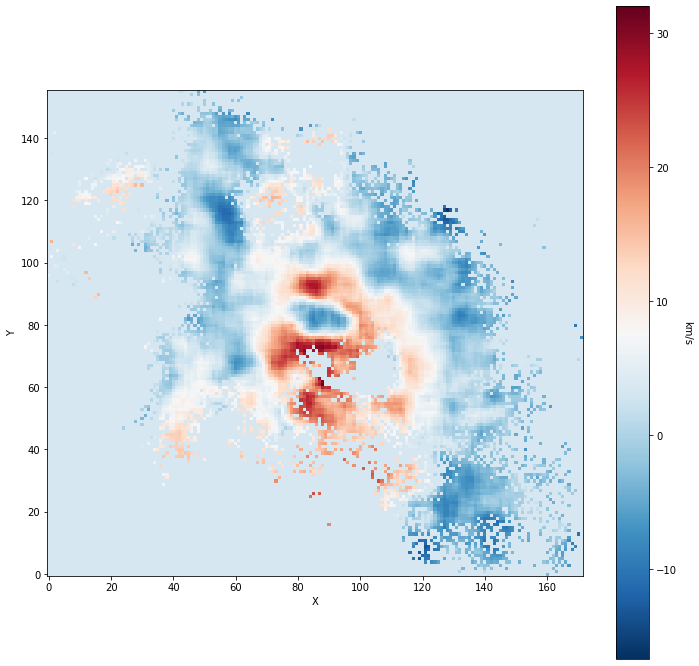

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))


dataRV=vv

plt.figure(1)
plt.imshow(dataRV, cmap='RdBu_r')

cbar = plt.colorbar()
#plt.clim(200,350)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')


#ax.text(0.9, 0.1, '10 pc',
#        verticalalignment='bottom', horizontalalignment='right',
#        transform=ax.transAxes,
#        color='black', fontsize=20)
    
#plt.axhline(y=50, xmin=0.59, xmax=0.925, linewidth=2, color = 'k')


plt.gca().invert_yaxis()

In [9]:
vv.shape

(156, 172)

In [10]:
img_hdu = create_fits_hdu(vv,0.26*u.arcsec,1 * u.deg,vv.shape,1 * u.GHz,u.K)


In [11]:
r0 = data["results_2sig"]['r0'][0] #pc
s0 = data["results_2sig"]['s0'][0] #pc
#k_r0 = (r0/( data['pix'] * data['pc']))**-1 #1/pix
#k_s0 = (s0/( data['pix'] * data['pc']))**-1 #1/pix
#k_r0, k_s0
r0,s0

(12.087616191694696, 2.107818040238321)

In [12]:
pspec = PowerSpectrum(img_hdu, distance=distance* u.pc) 

In [13]:
#pspec.run(verbose=True, xunit=u.pix**-1, low_cut=k_r0 / u.pix, high_cut=k_s0 / u.pix)
#pspec.run(verbose=True, xunit=u.pix**-1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     111.3
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           9.76e-18
Time:                        17:20:13   Log-Likelihood:                 55.382
No. Observations:                  98   AIC:                            -106.8
Df Residuals:                      96   BIC:                            -101.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4891      0.054     83.399      0.0

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\turbustat\statistics\elliptical_powerlaw.py:249: RuntimeWarning: divide by zero encountered in log10
  np.log10(x**2 * term1 + x * y * term2 + y**2 * term3)


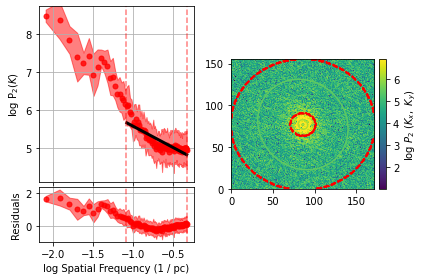

In [14]:
#pspec.run(verbose=True, xunit=u.pc**-1)
pspec.run(verbose=True, xunit=u.pc**-1, low_cut=(r0*u.pc)**-1, high_cut=(s0*u.pc)**-1)

sns.set_context("talk", font_scale=1.1)
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(pspec.freqs,pspec.ps1D)
#ax.scatter(pspec.freqs,pspec.ps1D_stddev)
ax.errorbar(np.array(pspec.freqs), pspec.ps1D, yerr=pspec.ps1D_stddev, ls=" ", elinewidth=0.4, alpha=1.0, c="k")

ax.axvline(1/r0, c="k")
ax.axvline(1/s0, c="k")

xgrid = np.linspace(1/r0,1/s0, 200)
ax.plot(xgrid, (10**4.6)*xgrid**pspec.slope, '-', c="k")

ax.set(xscale='log', yscale='log', 
       xlabel='log wavenumber $k$,1/pc',
       ylabel=r'log $P(k)_2,\ \mathrm{-}$'
      )

ax.text(.1, .20,name, transform=ax.transAxes)
ax.text(.1, .10,str(np.round(pspec.slope,2)) + '$\pm$' + str(np.round(pspec.slope_err,2)), transform=ax.transAxes)

ax.annotate('r0', xy=(1/r0, 1e8),  xycoords='data',
            xytext=(0.5, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.02),
            horizontalalignment='right', verticalalignment='top',
            )

ax.annotate('s0', xy=(1/s0, 1e8),  xycoords='data',
            xytext=(0.80, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.02),
            horizontalalignment='right', verticalalignment='top',
            )

In [16]:
!jupyter nbconvert --to script --no-prompt ps-TAU-N604-H.ipynb

[NbConvertApp] Converting notebook ps-TAU-N604-H.ipynb to script
[NbConvertApp] Writing 3377 bytes to ps-TAU-N604-H.py
